In [220]:
# Modèle théorique d'estimation des émissions sur le périphérique parisien
# Inspiré de la décomposition de Bigo (2020)

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

In [221]:
# --- Paramètres par défaut ---
def default_params():
    return {
        "distance_moyenne_km": 35,
        "demande_passagers_km": 35_000_000, # 35 * 100 000 voyageurs
        "part_voitures_thermiques": 0.7,
        "part_voitures_diesel": 0.2,
        "part_voitures_elec": 0.1,
        "conso_l_100km_essence_70": 7.0,
        "conso_l_100km_essence_50": 6.5,
        "conso_l_100km_diesel_70": 5.5,
        "conso_l_100km_diesel_50": 5.0,
        "conso_kWh_100km_elec_70": 17.0,
        "conso_kWh_100km_elec_50": 15.5,
        "emission_CO2_l_essence": 2.3,
        "emission_CO2_l_diesel": 2.6,
        "emission_CO2_kWh": 0.012,
        "emission_NOx_g_km_essence": 0.25,
        "emission_NOx_g_km_diesel": 0.6,
        "emission_NOx_g_km_elec": 0.01,
        "emission_PM10_g_km_essence": 0.01,
        "emission_PM10_g_km_diesel": 0.05,
        "emission_PM10_g_km_elec": 0.005,
        "taux_remplissage_actuel": 1.2,
        "taux_remplissage_covoit": 1.8,
        "part_covoiturage": 0.2,
        "duree_jours": 365,
        "part_temps_pointe": 0.31,
    }

In [222]:
def facteur_congestion(nb_vehicules, seuil, seuil_max, nb_voies):
    """
    Estime un facteur de surconsommation lié à la congestion, en fonction
    de la densité de trafic par voie.

    Le facteur renvoyé est utilisé pour ajuster la consommation énergétique 
    (carburant ou électricité) des véhicules lorsque la densité de trafic 
    augmente.

    Paramètres :
    - nb_vehicules : nombre total de véhicules sur le tronçon considéré
    - seuil : seuil de densité (veh/voie) à partir duquel la consommation commence à augmenter
    - seuil_max : densité à partir de laquelle la congestion est considérée comme forte
    - nb_voies : nombre de voies disponibles pour les véhicules considérés

    Retour :
    - Un facteur multiplicatif appliqué à la consommation (1.0 = trafic fluide, >1.0 = congestion)
    
    Comportement :
    - Si densité ≤ seuil        → consommation normale (facteur = 1.0)
    - Si seuil < densité ≤ max  → surconsommation modérée (croissance linéaire)
    - Si densité > seuil_max    → surconsommation sévère (facteur > 1.1)
    """

    densite = nb_vehicules / nb_voies

    if densite <= seuil:
        return 1.0
    elif densite <= seuil_max:
        return 1.0 + 0.1 * (densite - seuil) / (seuil_max - seuil)
    else:
        return 1.1 + 0.1 * (densite - seuil_max) / seuil_max

In [223]:
# --- Fonction d'estimation des émissions ---
def calcul_emissions(params, vitesse_reduite=False, part_temps=1.0, voie_covoit_activee=False):
    
    """
    Estime les émissions annuelles de CO₂, NOx et PM10 générées par les véhicules circulant
    sur le périphérique parisien, selon différents scénarios de trafic et de configuration routière.

    Cette fonction prend en compte :
    - La répartition des motorisations (essence, diesel, électrique)
    - Les effets de congestion sur la consommation énergétique
    - L'impact potentiel d'une voie réservée au covoiturage pendant les heures de pointe
    - La réduction de vitesse à 50 km/h (vs 70 km/h)

    MÉCANISME GÉNÉRAL :
    --------------------
    1. À partir d’une demande exprimée en passager.kilomètres (D), et d’hypothèses
       sur le taux de remplissage, on estime le nombre de véhicules nécessaires (n).

    2. Les seuils de congestion (début et saturation) sont ensuite adaptés automatiquement
       à la valeur de n pour assurer une cohérence du modèle, quel que soit le trafic simulé.

    3. Trois cas de figure sont ensuite distingués :

        a. Cas normal (sans voie covoiturage OU hors heures de pointe) :
           → Tous les véhicules sont répartis uniformément sur les 4 voies.

        b. Cas avec voie covoiturage active (heures de pointe, ≤ 25% véhicules prioritaires) :
           → Séparation des flux :
              - Véhicules prioritaires (covoitureurs + bus, taxis, etc.) sur 1 voie
              - Véhicules classiques sur 3 voies
           → Congestion et émissions calculées séparément pour chaque groupe.

        c. Cas avec voie covoiturage active (mais > 25% de véhicules prioritaires) :
           → La voie prioritaire serait surchargée.
           → On désactive le dispositif : retour à une répartition homogène sur les 4 voies.

    4. Les émissions sont calculées pour chaque type de motorisation, en intégrant :
       - La distance moyenne parcourue
       - Le facteur de surconsommation dû à la congestion
       - Les coefficients d’émissions par carburant ou électricité

    PARAMÈTRES :
    -------------
    - params : dictionnaire contenant tous les paramètres du modèle
    - vitesse_reduite : booléen indiquant si la vitesse est réduite à 50 km/h (True) ou non (False)
    - part_temps : part du temps journalier concerné (ex : 0.31 pour les heures de pointe)
    - voie_covoit_activee : booléen indiquant si la voie de covoiturage est activée pendant la période

    RETOUR :
    --------
    - Un dictionnaire contenant les émissions annuelles totales de :
        {"CO2": ..., "NOx": ..., "PM10": ...}
    (les valeurs sont exprimées en tonnes/an)
    """

    # --- Paramètres de base ---
    d = params["distance_moyenne_km"]                   # distance moyenne par véhicule
    D = params["demande_passagers_km"]                  # demande totale (en pass.km)
    jours = params["duree_jours"]                       # nombre de jours considérés

    # Calcul automatique de la part de personnes voyageant seules (non-covoiturées)
    part_solo = 1 - params["part_covoiturage"]

    # Centré sur les personnes (80% voyagent seuls)
    r = 1 / (part_solo / 1.0 + params["part_covoiturage"] / params["taux_remplissage_covoit"]) #combien de personnes en moyenne transp. par 1 véhicule basé sur comportement des gens

    # Nombre total de véhicules requis
    n = D / (r * d)
    print(f"\n>>> Nombre de véhicules ajusté : {n:.0f}")

    # Seuils calculés automatiquement : proportionnels au nombre de véhicules
    # -> seuil = début de congestion à x% de densité
    # -> seuil_max = congestion sévère à y% de densité
    SEUIL_RELATIF = 0.25   # congestion commence quand 25% des véhicules sont sur une voie
    SEUIL_MAX_RELATIF = 0.5  # congestion sévère à 50% des véhicules sur une voie

    seuil = n * SEUIL_RELATIF
    seuil_max = n * SEUIL_MAX_RELATIF

    # --- Cas spécial : voie de covoiturage active aux heures de pointe ---

    if voie_covoit_activee and part_temps == params["part_temps_pointe"]:

        print(">>> Mode spécial : voie covoiturage activée aux heures de pointe")


        # Calcule la part de véhicules qui peuvent utiliser la voie réservée
        # Inclure une base minimale de véhicules autorisés à utiliser la voie (ex: bus, VTC, secours)
        base_vehicules_autorises = 0.05  # 5%
        part_prioritaire = base_vehicules_autorises + params["part_covoiturage"]
        part_prioritaire = min(part_prioritaire, 1.0)
        part_classique = 1 - part_prioritaire

        # si vhc prioritaires > 25% :
        if part_prioritaire >= 0.25:
            print(">>> Trop de véhicules prioritaires : retour à répartition sur 4 voies")
            # on traite comme le mode classique sur 4 voies, mais avec la vitesse réduite
            congestion = facteur_congestion(n, seuil, seuil_max, nb_voies=4)

            result = {"CO2": 0, "NOx": 0, "PM10": 0}
            for type_v, part in [
                ("essence", params["part_voitures_thermiques"]),
                ("diesel", params["part_voitures_diesel"]),
                ("elec", params["part_voitures_elec"])
            ]:
                if type_v == "essence":
                    conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
                    CO2e = params["emission_CO2_l_essence"]
                    NOx = params["emission_NOx_g_km_essence"]
                    PM = params["emission_PM10_g_km_essence"]
                elif type_v == "diesel":
                    conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
                    CO2e = params["emission_CO2_l_diesel"]
                    NOx = params["emission_NOx_g_km_diesel"]
                    PM = params["emission_PM10_g_km_diesel"]
                else:
                    conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
                    CO2e = params["emission_CO2_kWh"]
                    NOx = params["emission_NOx_g_km_elec"]
                    PM = params["emission_PM10_g_km_elec"]

                km_total = part * n * d * part_temps
                consommation_totale = km_total * (conso / 100) * congestion
                result["CO2"] += consommation_totale * CO2e / 1000 * jours
                result["NOx"] += km_total * NOx / 1_000_000 * jours
                result["PM10"] += km_total * PM / 1_000_000 * jours

            return result  
        
        # --- Cas classique de voie covoiturage activée < 25% ---
        
        n_prioritaire = n * part_prioritaire
        n_classique = n * part_classique

        # congestion dynamique selon la part de la voie utilisée
        congestion_p = facteur_congestion(n_prioritaire, seuil, seuil_max, nb_voies=1)
        congestion_c = facteur_congestion(n_classique, seuil, seuil_max, nb_voies=3)

        print(f"  → part_prioritaire : {part_prioritaire:.4f}")
        print(f"  → densité prio : {n_prioritaire:.0f} / 1 voie = {n_prioritaire:.0f}")
        print(f"  → densité classique : {n_classique:.0f} / 3 voies = {n_classique/3:.0f}")
        print(f"  → congestion prio : {congestion_p:.4f}")
        print(f"  → congestion classique : {congestion_c:.4f}")

        result = {"CO2": 0, "NOx": 0, "PM10": 0}

        for n_groupe, congestion in [
            (n_prioritaire, congestion_p),
            (n_classique, congestion_c)
        ]:
            for type_v, part_motor in [
                ("essence", params["part_voitures_thermiques"]),
                ("diesel", params["part_voitures_diesel"]),
                ("elec", params["part_voitures_elec"])
            ]:
                if type_v == "essence":
                    conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
                    CO2e = params["emission_CO2_l_essence"]
                    NOx = params["emission_NOx_g_km_essence"]
                    PM = params["emission_PM10_g_km_essence"]
                elif type_v == "diesel":
                    conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
                    CO2e = params["emission_CO2_l_diesel"]
                    NOx = params["emission_NOx_g_km_diesel"]
                    PM = params["emission_PM10_g_km_diesel"]
                else:
                    conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
                    CO2e = params["emission_CO2_kWh"]
                    NOx = params["emission_NOx_g_km_elec"]
                    PM = params["emission_PM10_g_km_elec"]

                km_total = part_motor * n_groupe * d * part_temps
                consommation_totale = km_total * (conso / 100) * congestion
                result["CO2"] += consommation_totale * CO2e / 1000 * jours
                result["NOx"] += km_total * NOx / 1_000_000 * jours
                result["PM10"] += km_total * PM / 1_000_000 * jours

    # --- Cas classique : tous les véhicules traités ensemble ---
    else:
        congestion = facteur_congestion(n, params["seuil_congestion"], params["seuil_max_congestion"], nb_voies=4)

        result = {"CO2": 0, "NOx": 0, "PM10": 0}

        for type_v, part in [
            ("essence", params["part_voitures_thermiques"]),
            ("diesel", params["part_voitures_diesel"]),
            ("elec", params["part_voitures_elec"])
        ]:
            if type_v == "essence":
                conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
                CO2e = params["emission_CO2_l_essence"]
                NOx = params["emission_NOx_g_km_essence"]
                PM = params["emission_PM10_g_km_essence"]
            elif type_v == "diesel":
                conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
                CO2e = params["emission_CO2_l_diesel"]
                NOx = params["emission_NOx_g_km_diesel"]
                PM = params["emission_PM10_g_km_diesel"]
            else:
                conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
                CO2e = params["emission_CO2_kWh"]
                NOx = params["emission_NOx_g_km_elec"]
                PM = params["emission_PM10_g_km_elec"]

            km_total = part * n * d * part_temps
            consommation_totale = km_total * (conso / 100) * congestion
            result["CO2"] += consommation_totale * CO2e / 1000 * jours
            result["NOx"] += km_total * NOx / 1_000_000 * jours
            result["PM10"] += km_total * PM / 1_000_000 * jours

    return result

In [224]:
# --- Fusion pointe / hors-pointe ---
def emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False):
    """
    Calcule les émissions annuelles totales (CO₂, NOx, PM10) en distinguant
    les heures de pointe et les heures hors-pointe.

    Cette fonction appelle deux fois la fonction `calcul_emissions` :
    - une première fois pour les heures de pointe (avec ou sans voie de covoiturage activée),
    - une seconde fois pour les heures creuses (toujours sans voie de covoiturage).

    L’intérêt de cette séparation est de refléter les conditions de circulation
    variables au cours de la journée (trafic plus dense, vitesse réduite, effets
    de la voie réservée, etc.).

    PARAMÈTRES :
    ------------
    - params : dictionnaire des paramètres du modèle
    - vitesse_reduite : booléen indiquant si la vitesse est réduite à 50 km/h ou non
    - voie_covoit_activee : booléen indiquant si la voie de covoiturage est activée
      pendant les heures de pointe (inutile hors-pointe)

    MÉCANISME :
    -----------
    - On décompose la journée en deux parties :
        - heures de pointe : proportion définie par `params["part_temps_pointe"]`
        - heures hors-pointe : le reste de la journée
    - Les émissions sont calculées séparément pour chaque période
      en tenant compte du contexte de trafic (ex : covoiturage activé ou non).
    - Les émissions des deux périodes sont ensuite additionnées pour
      obtenir les émissions totales annuelles.

    RETOUR :
    --------
    - Dictionnaire contenant les émissions totales par polluant :
      {"CO2": ..., "NOx": ..., "PM10": ...} en tonnes par an.
    """

    # --- Répartition du temps ---
    part_pointe = params["part_temps_pointe"]  # part du temps journalier en heure de pointe (ex. 0.31)
    part_off = 1 - part_pointe                 # part du temps en heure creuse (hors-pointe)

    # --- Ajustement de la surconsommation aux heures de pointe ---
    # (ancien système — plus utilisé ici, mais laissé par sécurité)
    #surconso_pointe = params["surconso_congestion_pointe"]
    #if voie_covoit_activee:
        # Si la voie covoiturage est active, on réduit un peu la surconsommation estimée
        #surconso_pointe = min(1.05, surconso_pointe - 0.05)

    # --- Calcul des émissions pour les heures de pointe ---
    res_pointe = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_pointe,
        voie_covoit_activee=voie_covoit_activee  # on active la logique des 2 groupes si demandé
    )

    # --- Calcul des émissions pour les heures hors-pointe ---
    res_off = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_off,
        voie_covoit_activee=False  # la voie covoiturage est inactive hors-pointe
    )

    # --- Somme des émissions totales sur l’année ---
    total = {
        k: res_pointe[k] + res_off[k] for k in res_pointe
    }
    return total


In [225]:
# --- Affichage ---
def afficher_resultats(params):
    scenarios = {
        "A. 70 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False),
        "B. 50 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=False),
        "C. 50 km/h avec voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    }

    for nom, valeurs in scenarios.items():
        print(f"\n{nom} :")
        for polluant, val in valeurs.items():
            print(f"  {polluant} : {val:.2f} t/an")

    labels = list(scenarios.keys())
    CO2_vals = [scenarios[k]["CO2"] for k in labels]
    NOx_vals = [scenarios[k]["NOx"] for k in labels]
    PM10_vals = [scenarios[k]["PM10"] for k in labels]

    x = np.arange(len(labels))
    width = 0.25

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # CO2
    axes[0].bar(labels, CO2_vals, color='green')
    axes[0].set_title("Émissions de CO₂")
    axes[0].set_ylabel("t/an")
    axes[0].tick_params(axis='x', rotation=20)

    # NOx
    axes[1].bar(labels, NOx_vals, color='orange')
    axes[1].set_title("Émissions de NOx")
    axes[1].tick_params(axis='x', rotation=20)

    # PM10
    axes[2].bar(labels, PM10_vals, color='gray')
    axes[2].set_title("Émissions de PM10")
    axes[2].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Interface interactive ---
@interact(
    distance_moyenne_km=FloatSlider(min=10, max=50, step=1, value=35, description="km/jour"),
    part_covoiturage=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.2, description="% covoiturage"),
    surconso_congestion_pointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.1, description="Surconso pointe"),
    surconso_congestion_offpointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.0, description="Surconso hors-pointe"),
    seuil_congestion=FloatSlider(min=50000, max=200000, step=5000, value=100000, description="Seuil congestion"),
    seuil_max_congestion=FloatSlider(min=100000, max=300000, step=5000, value=200000, description="Seuil max congestion")
)
def simulation_interactive(distance_moyenne_km, part_covoiturage,
                           surconso_congestion_pointe, surconso_congestion_offpointe,
                           seuil_congestion, seuil_max_congestion):
    params = default_params()
    params.update({
    "distance_moyenne_km": distance_moyenne_km,
    "part_covoiturage": part_covoiturage,
    "surconso_congestion_pointe": surconso_congestion_pointe,
    "surconso_congestion_offpointe": surconso_congestion_offpointe,
    "seuil_congestion": seuil_congestion,
    "seuil_max_congestion": seuil_max_congestion
})
    afficher_resultats(params)

interactive(children=(FloatSlider(value=35.0, description='km/jour', max=50.0, min=10.0, step=1.0), FloatSlide…


>>> Nombre de véhicules ajusté : 1000000
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0500
  → densité prio : 50000 / 1 voie = 50000
  → densité classique : 950000 / 3 voies = 316667
  → congestion prio : 1.0000
  → congestion classique : 1.0267

>>> Nombre de véhicules ajusté : 1000000

>>> Nombre de véhicules ajusté : 995556
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0600
  → densité prio : 59733 / 1 voie = 59733
  → densité classique : 935822 / 3 voies = 311941
  → congestion prio : 1.0000
  → congestion classique : 1.0253

>>> Nombre de véhicules ajusté : 995556

>>> Nombre de véhicules ajusté : 991111
>>> Mode spécial : voie covoiturage activée aux heures de pointe
  → part_prioritaire : 0.0700
  → densité prio : 69378 / 1 voie = 69378
  → densité classique : 921733 / 3 voies = 307244
  → congestion prio : 1.0000
  → congestion classique : 1.0240

>>> Nombre de véhicules ajusté : 991111

>

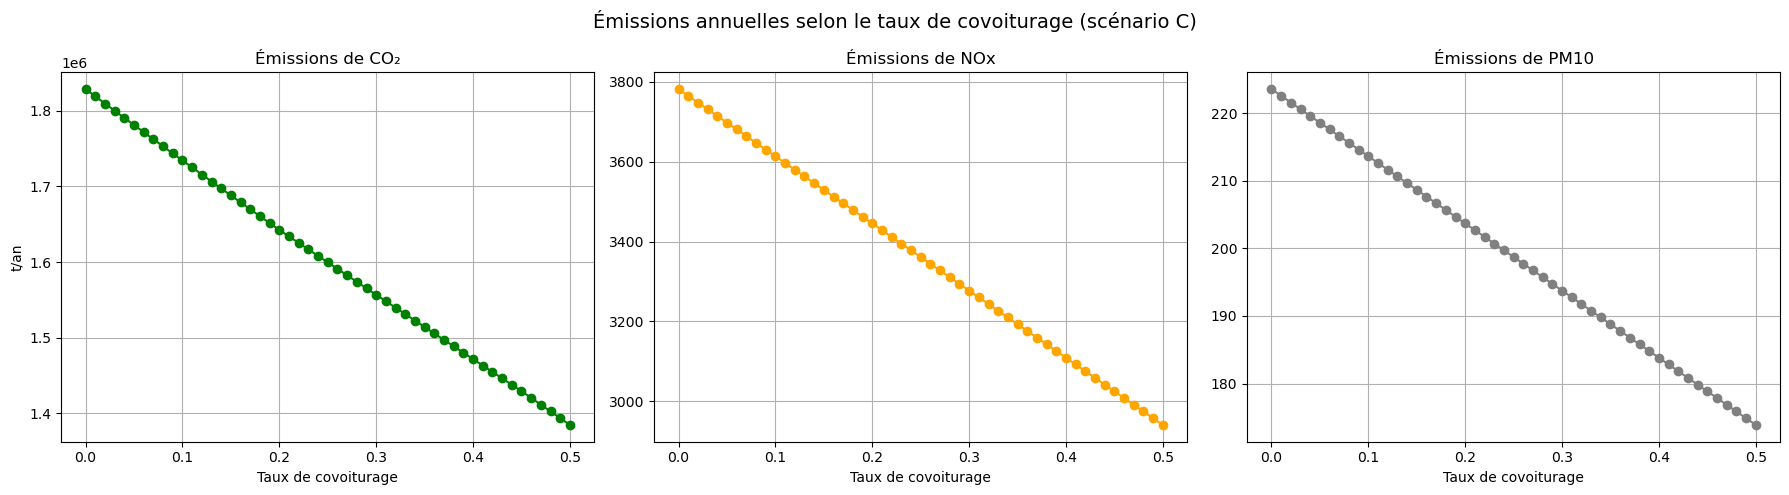

In [227]:
# --- Visualisation des émissions selon le taux de covoiturage ---
covoit_range = np.linspace(0, 0.5, 51)
CO2_vals = []
NOx_vals = []
PM10_vals = []

for cov in covoit_range:
    params = default_params()
    params.update({
        "part_covoiturage": cov,
        "surconso_congestion_pointe": 1.1,
        "surconso_congestion_offpointe": 1.0,
        "seuil_congestion": 100000,
        "seuil_max_congestion": 200000
    })
    emissions = emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    CO2_vals.append(emissions["CO2"])
    NOx_vals.append(emissions["NOx"])
    PM10_vals.append(emissions["PM10"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(covoit_range, CO2_vals, marker='o', color='green')
axes[0].set_title("Émissions de CO₂")
axes[0].set_xlabel("Taux de covoiturage")
axes[0].set_ylabel("t/an")
axes[0].grid(True)

axes[1].plot(covoit_range, NOx_vals, marker='o', color='orange')
axes[1].set_title("Émissions de NOx")
axes[1].set_xlabel("Taux de covoiturage")
axes[1].grid(True)

axes[2].plot(covoit_range, PM10_vals, marker='o', color='gray')
axes[2].set_title("Émissions de PM10")
axes[2].set_xlabel("Taux de covoiturage")
axes[2].grid(True)

plt.suptitle("Émissions annuelles selon le taux de covoiturage (scénario C)", fontsize=14)
plt.tight_layout()
plt.show()